In [1]:
!pip install praw pandas seaborn scipy

In [2]:
import csv
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
from typing import Callable

from util import *
import validate

sns.set_theme()

In [3]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.WARN)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [4]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [5]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

In [6]:
first_id = int("c000000", 36)  # todo find the ID of the first post we want to analyze
# Earliest post I can find: https://www.reddit.com/api/info.json?id=t1_c015001
last_id = int("l000000", 36)  # todo find the ID of the last post we want to analyze

## Load comments

In [7]:
runs = get_runs()
missing_runs = validate.missing_runs(runs.keys())
assert len(missing_runs) == 0, missing_runs

In [8]:
df = load_comments(*runs.values())
df

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,43535679895,2023-09-10 14:35:57,itookapicture,9zxaw2zhs,t3_16f7sey,t3_16f7sey,2,0,April 2022 23:52 after the Tyson Fury fight
1,43535679895,2023-09-10 14:35:57,itookapicture,9zxaw2zhs,t3_16f7sey,t3_16f7sey,2,0,April 2022 23:52 after the Tyson Fury fight
2,43535740891,2023-09-10 14:44:16,CautiousBB,NaN,t3_16f3y5s,t3_16f3y5s,5,0,8 weeks is too early for a mucus plug. CM can ...
3,43535740891,2023-09-10 14:44:16,CautiousBB,NaN,t3_16f3y5s,t3_16f3y5s,5,0,8 weeks is too early for a mucus plug. CM can ...
4,43535775625,2023-09-10 14:48:42,Music,5oegbwgv,t1_jzyekbk,t3_16expzg,2,0,Yup. Currently anything less than 50 years old...
...,...,...,...,...,...,...,...,...,...
3329,45503314295,2024-03-25 16:34:57,ynab,rehou,t3_1bnedeu,t3_1bnedeu,3,0,"You're mostly there, but here's what you're mi..."
3330,45503412282,2024-03-25 16:46:28,science,NaN,t3_1bn8gfq,t3_1bn8gfq,1,0,Uncover? Do they think they’re sleuths? 5 minu...
3331,45503412282,2024-03-25 16:46:28,science,NaN,t3_1bn8gfq,t3_1bn8gfq,1,0,Uncover? Do they think they’re sleuths? 5 minu...
3332,45503445802,2024-03-25 16:50:26,AskReddit,9a9u1dry,t3_1bn81jt,t3_1bn81jt,1,0,My nails are always done 💅


In [9]:
misses = load_misses(*runs.values())
misses

530    14943667465910379
197    14943667465910379
651    14943667522829364
318    14943667522829364
293    14943667590010017
             ...        
497    15146543458687869
226    15146543702144275
559    15146543702144275
144    15146545877430777
477    15146545877430777
Length: 666, dtype: int64

In [10]:
# Sanity checks
validate.validate(df, misses)

❌ Found comments with duplicate IDs (call validate.duplicate_comments for more info)
Bad rows:
               id                time        sr_name  author_id  \
0     43535679895 2023-09-10 14:35:57  itookapicture  9zxaw2zhs   
1     43535679895 2023-09-10 14:35:57  itookapicture  9zxaw2zhs   
2     43535740891 2023-09-10 14:44:16     CautiousBB        NaN   
3     43535740891 2023-09-10 14:44:16     CautiousBB        NaN   
4     43535775625 2023-09-10 14:48:42          Music   5oegbwgv   
...           ...                 ...            ...        ...   
3329  45503314295 2024-03-25 16:34:57           ynab      rehou   
3330  45503412282 2024-03-25 16:46:28        science        NaN   
3331  45503412282 2024-03-25 16:46:28        science        NaN   
3332  45503445802 2024-03-25 16:50:26      AskReddit   9a9u1dry   
3333  45503445802 2024-03-25 16:50:26      AskReddit   9a9u1dry   

     parent_fullname     post_id  upvotes  downvotes  \
0         t3_16f7sey  t3_16f7sey        2   

In [11]:
# The first ID we actually collected
first_id_actual = df[ID].min()
first_id_actual, np.base_repr(first_id_actual, 36)

(43535679895, 'K000PLJ')

#### Actual analysis

In [12]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [13]:
df[BODY] = df[BODY].map(lambda body: body.lower().strip())
matched_rows = df[df[BODY].map(matches)]
matched_rows

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
160,43540858189,2023-09-11 04:46:47,trees,1dwia2ii,t3_16ff6wv,t3_16ff6wv,0,0,least addicted weed smoker
161,43540858189,2023-09-11 04:46:47,trees,1dwia2ii,t3_16ff6wv,t3_16ff6wv,0,0,least addicted weed smoker
168,43541346403,2023-09-11 06:55:35,Parenting,464f1q2,t1_k02vda6,t3_16fg3cl,21,0,a psychopath says something like that.
169,43541346403,2023-09-11 06:55:35,Parenting,464f1q2,t1_k02vda6,t3_16fg3cl,21,0,a psychopath says something like that.
192,43542051006,2023-09-11 09:10:14,electronic_cigarette,8vt43lsw,t1_k03p0qw,t3_16fp7te,-5,0,the clouds from disposables can appear douchey...
...,...,...,...,...,...,...,...,...,...
2631,45480326543,2024-03-23 01:43:41,Truckers,45u90xre,t1_kw5lzj4,t3_1bli9ox,20,0,they're just depressing and they take every ou...
2960,45490500478,2024-03-24 08:16:13,AskUK,yh1vzpe,t3_1bmis53,t3_1bmis53,9,0,> some people may genuinely not have had an op...
2961,45490500478,2024-03-24 08:16:13,AskUK,yh1vzpe,t3_1bmis53,t3_1bmis53,9,0,> some people may genuinely not have had an op...
3176,45498213469,2024-03-25 03:48:59,moreplatesmoredates,5noajrqj,t1_kwfy9py,t3_1bmwuli,2,0,"that's just two in one win i assume, the main ..."


In [14]:
{
    keyword: len(matched_rows[matched_rows[BODY].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 6,
 'gaslight': 0,
 'trigger': 6,
 'toxic': 6,
 'woke': 6,
 'manipulat': 2,
 'microaggression': 0,
 'autis': 0,
 'adhd': 2,
 'ocd': 2,
 'ptsd': 2,
 'bipolar': 0,
 'anxiety': 6,
 'depress': 10,
 'psycho': 8,
 'delusion': 0,
 'delulu': 0,
 'solulu': 0,
 'addict': 10,
 'abus': 4,
 'unstable': 0,
 'narcissis': 4,
 'neurodivergen': 0}

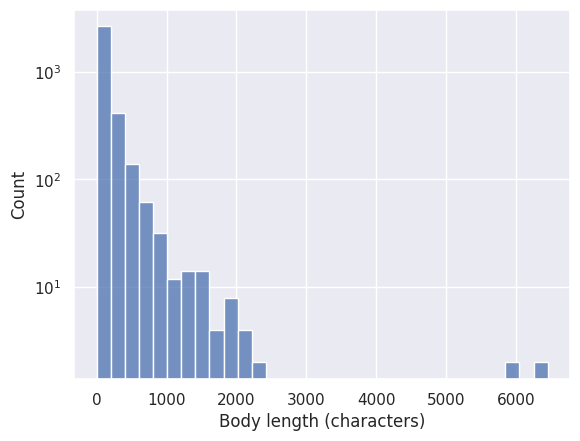

In [15]:
lengths = df[BODY].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [16]:
df[lengths >= 10000]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body


### Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

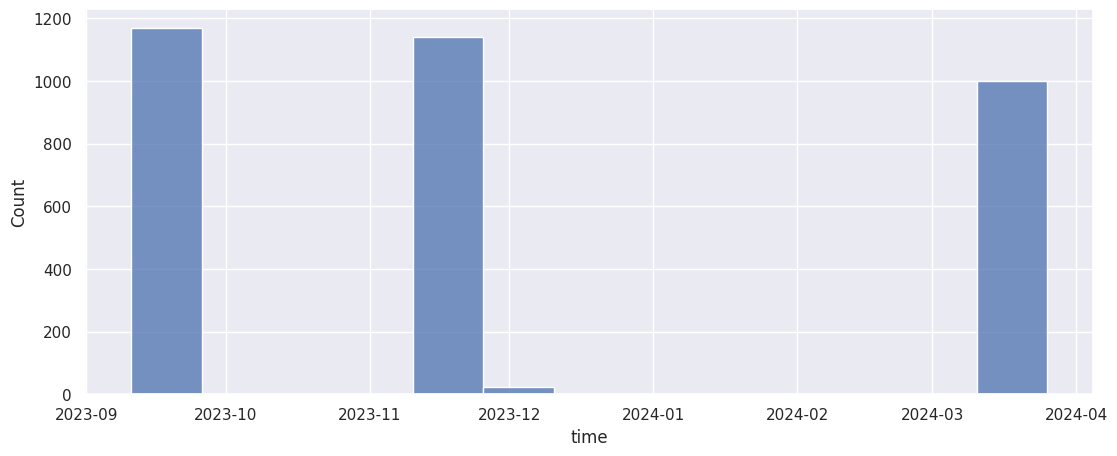

In [17]:
from datetime import timedelta

plt.figure(figsize=(13, 5))
# TODO figure out how to get binwidth to work with timedeltas
sns.histplot(data=df, x=TIME) #, binwidth=timedelta(days=30))

<Axes: xlabel='time', ylabel='Count'>

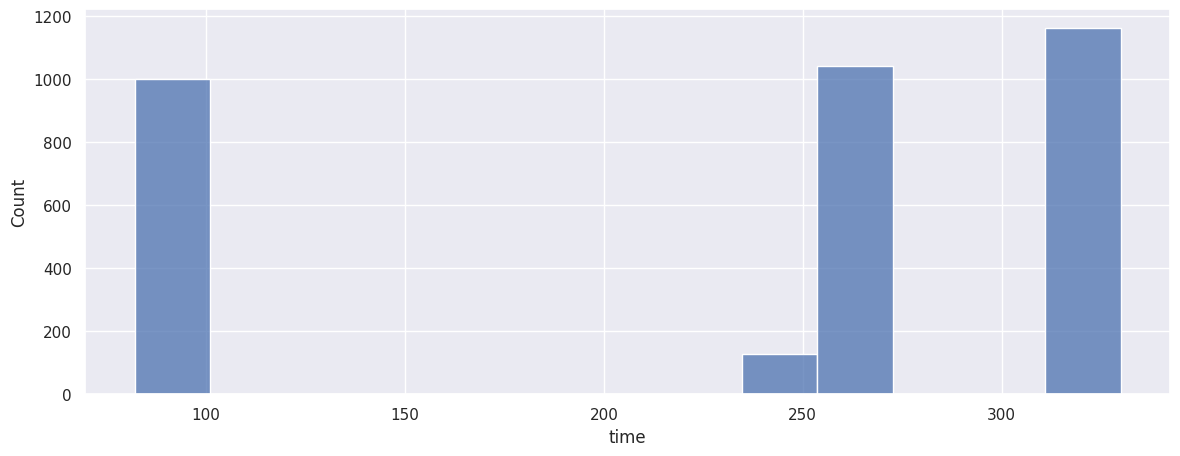

In [18]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df[TIME].apply(lambda t: int(t.strftime("%j"))))

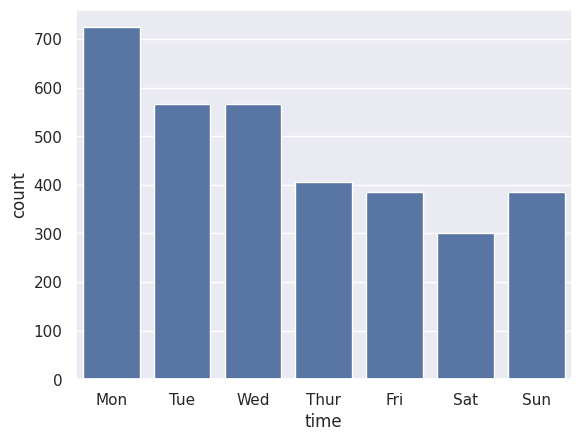

In [19]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df[TIME].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

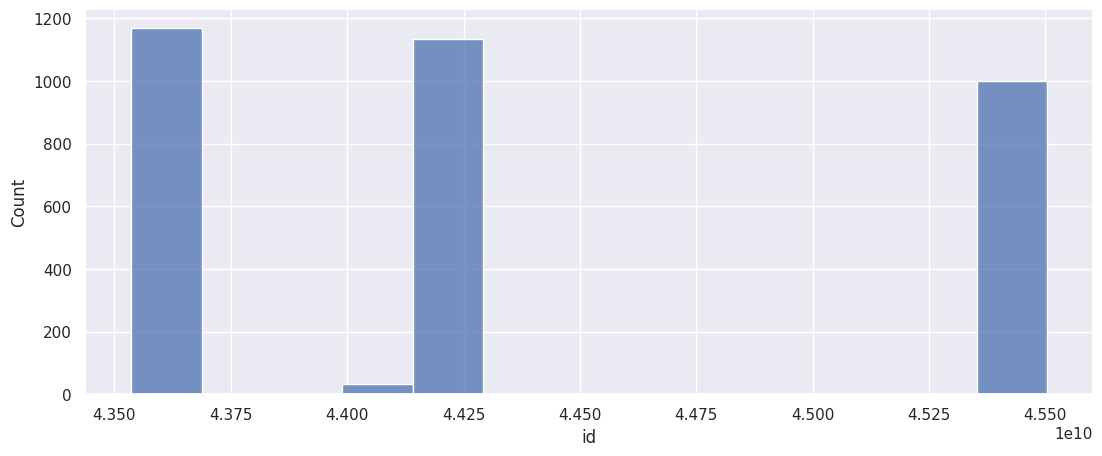

In [20]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df[ID])

In [21]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df[ID].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.3997129780145087, pvalue=0.0, statistic_location=0.3003470099878908, statistic_sign=1)

In [22]:
# The earliest comment we have
df[df[ID] == df[ID].min()]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body
0,43535679895,2023-09-10 14:35:57,itookapicture,9zxaw2zhs,t3_16f7sey,t3_16f7sey,2,0,april 2022 23:52 after the tyson fury fight
1,43535679895,2023-09-10 14:35:57,itookapicture,9zxaw2zhs,t3_16f7sey,t3_16f7sey,2,0,april 2022 23:52 after the tyson fury fight


<Axes: >

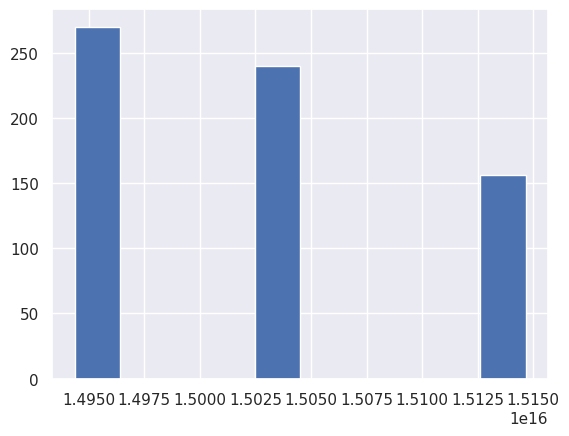

In [23]:
misses.hist()

KeyboardInterrupt: 

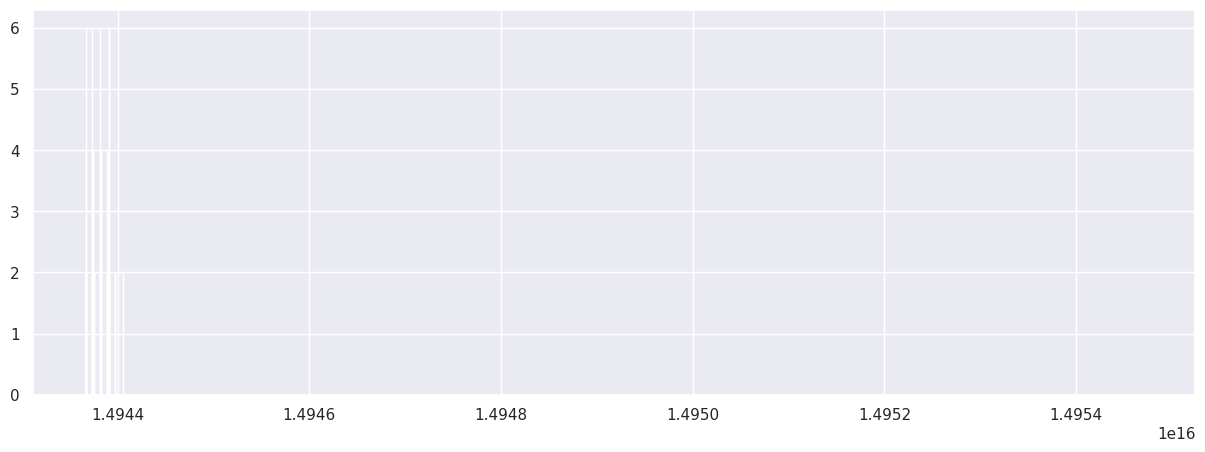

In [24]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: >

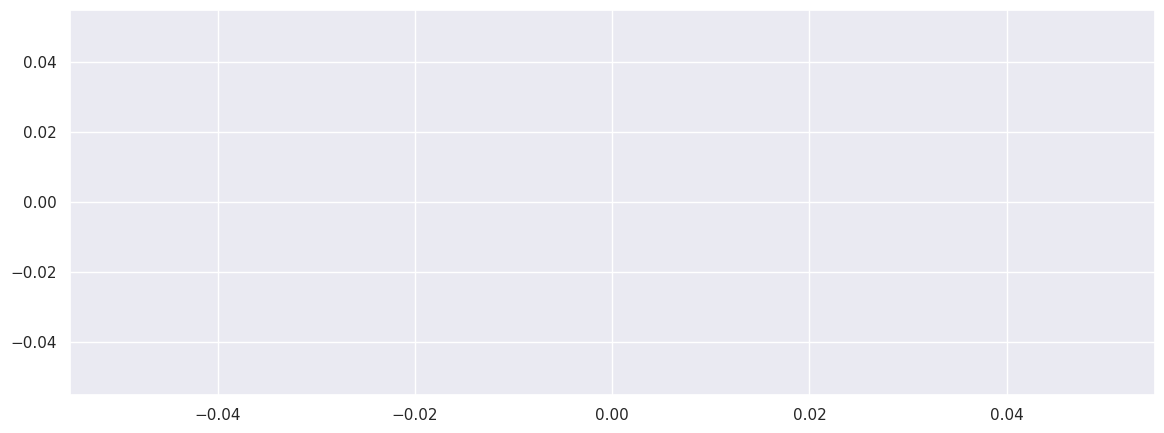

In [26]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [28]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.8335, 0.8335)

In [29]:
# Hit rate over time
start = first_id_actual
end = max(df.iloc[len(df) - 1][ID],
          misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df[ID]) & (df[ID] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "ID": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

KeyboardInterrupt: 

In [30]:
df[(3e10 <= df[ID]) & (df[ID] < 3.75e10)]

,id,time,sr_name,author_id,parent_fullname,post_id,upvotes,downvotes,body


In [ ]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = misses_actual.map(
    lambda id: (id - misses_actual.mean()) / (misses_actual.std())
)
res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.12137782532388652, pvalue=9.498360451644489e-43, statistic_location=-0.19669160654014647, statistic_sign=1)

## Subreddits

In [ ]:
df[df[SR_NAME] == "reddit.com"]

,index,name,subreddit,time,body,id
0,91535,c02m7ii,reddit.com,2007-12-07 11:14:13,"London doesn't do it with every street, and th...",26125783434
2,101518,c031764,reddit.com,2008-01-30 00:31:42,because it takes all day to vote?,26126482828
3,75169,c035sd1,reddit.com,2008-02-12 08:22:36,"I doubt this will happen, the ISPs will fight ...",26126696917
4,103066,c03e4tj,reddit.com,2008-03-08 19:29:46,I thought the same when I finished the story a...,26127086311
7,97189,c03lq7n,reddit.com,2008-04-01 18:21:39,What does one of hip-hop's most [illustrious p...,26127440627
8,94094,c03tl2a,reddit.com,2008-04-25 10:34:06,The guys they killed all had rap sheets. I do...,26127807202
11,96050,c04bp9c,reddit.com,2008-06-11 22:06:21,"the dad is ""fucked""? maybe he shouldn't have ...",26128652448
12,99116,c04gzsw,reddit.com,2008-06-25 02:31:59,I hope so.,26128899392
13,59575,c04ifpz,reddit.com,2008-06-28 06:09:58,"He ""wants to attack Iran""? Uh. Source please....",26128966679
15,78079,c04qtpi,reddit.com,2008-07-18 19:13:36,this pope is none of that. he is RESPONSIBLE f...,26129358054


In [31]:
# Most popular subreddits
df[SR_NAME].value_counts().nlargest(20)

sr_name
AskReddit               58
teenagers               28
AmItheAsshole           20
nfl                     14
wallstreetbets          14
AITAH                   12
ask                     12
CollegeBasketball       10
ImTheMainCharacter      10
tipofmytongue           10
mildlyinfuriating       10
JoeRogan                10
NoStupidQuestions       10
WhitePeopleTwitter      10
politics                10
MeJulgue                 8
FemBoys                  8
TrueUnpopularOpinion     8
fantasyfootball          8
PeterExplainsTheJoke     8
Name: count, dtype: int64